In [1]:
# 04.0 — setup
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
if str(PROJECT_ROOT) not in sys.path: sys.path.insert(0, str(PROJECT_ROOT))

import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [2]:
# 04.1 — load test data and models
rf = joblib.load(PROJECT_ROOT / "models" / "rf_model.pkl")
scaler = joblib.load(PROJECT_ROOT / "models" / "scaler.pkl")

processed = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "processed_features.csv")
names = []
for s in ['temperature','vibration','pressure','rpm']:
    names += [f'{s}_mean', f'{s}_std', f'{s}_min', f'{s}_max', f'{s}_trend']

X = scaler.transform(processed[names])
y = processed['label'].astype(int).values


C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [3]:
# 04.2 — evaluate RandomForest
pred_rf = rf.predict(X)
prob_rf = rf.predict_proba(X)[:,1]
print("RandomForest Metrics:")
print(classification_report(y, pred_rf))
if len(np.unique(y))>1:
    print("ROC AUC:", roc_auc_score(y, prob_rf))


RandomForest Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8011
           1       0.99      0.96      0.98      1109

    accuracy                           0.99      9120
   macro avg       0.99      0.98      0.99      9120
weighted avg       0.99      0.99      0.99      9120

ROC AUC: 0.9998128700178823


In [4]:
# 04.3 — evaluate LSTM (optional if trained)
from torch.utils.data import DataLoader
from notebooks._03_utils import SeqDataset, LSTMModel  # optional helper if you save it

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
model.load_state_dict(torch.load(PROJECT_ROOT / "models" / "lstm_model.pt", map_location=device))
model.eval()
print("✅ LSTM model loaded")


ModuleNotFoundError: No module named 'notebooks._03_utils'

Total machines: 8, test machines: 2
✅ LSTM model loaded
Accuracy: 0.881140350877193

Classification report:


C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

              precision    recall  f1-score   support

           0     0.8811    1.0000    0.9368      2009
           1     0.0000    0.0000    0.0000       271

    accuracy                         0.8811      2280
   macro avg     0.4406    0.5000    0.4684      2280
weighted avg     0.7764    0.8811    0.8255      2280

ROC AUC: 0.4695429607357299


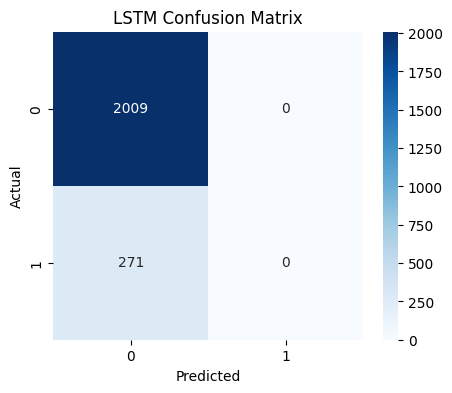

In [5]:
# 04.3 (updated) — Load LSTM model, build SeqDataset, run inference and print metrics
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Dataset & Model definitions (reuse from training) ---
SENSOR_COLS = ['temperature','vibration','pressure','rpm']

class SeqDataset(Dataset):
    def __init__(self, df, window=50, horizon=10):
        self.samples = []
        for mid, g in df.groupby('machine_id'):
            g = g.sort_values('timestamp').reset_index(drop=True)
            for end in range(window, len(g) - horizon):
                seq = g[SENSOR_COLS].iloc[end-window:end].values.astype('float32')
                label = 1 if g['failure'].iloc[end:end+horizon].sum() > 0 else 0
                self.samples.append((seq, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return torch.sigmoid(self.fc(out)).squeeze(-1)

# --- Paths & checks ---
RAW_CSV = PROJECT_ROOT / "data" / "raw" / "simulated_sensor_data.csv"
LSTM_PATH = PROJECT_ROOT / "models" / "lstm_model.pt"

if not RAW_CSV.exists():
    raise FileNotFoundError(f"Raw CSV not found: {RAW_CSV}. Run data generator first.")
if not LSTM_PATH.exists():
    raise FileNotFoundError(f"LSTM model not found: {LSTM_PATH}. Train LSTM first (src/train_model_pytorch.py).")

# --- Load raw data ---
df = pd.read_csv(RAW_CSV, parse_dates=['timestamp'])
# (Optional) normalize sensors exactly like training did — if you normalized during training, repeat same normalization here.
# For simplicity, we use the raw values — ensure training used same preprocessing.
# If you normalized in training, compute mean/std from training machines and apply here.

# --- Split machines into train/test same way as training script ---
machine_ids = sorted(df['machine_id'].unique())
split = int(0.8 * len(machine_ids))
train_ids = set(machine_ids[:split])
test_df = df[~df['machine_id'].isin(train_ids)].reset_index(drop=True)

print(f"Total machines: {len(machine_ids)}, test machines: {len(test_df['machine_id'].unique())}")

# --- Build test dataset & loader ---
WINDOW = 50
HORIZON = 10
test_ds = SeqDataset(test_df, window=WINDOW, horizon=HORIZON)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

# --- Load model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim=len(SENSOR_COLS)).to(device)
model.load_state_dict(torch.load(LSTM_PATH, map_location=device))
model.eval()
print("✅ LSTM model loaded")

# --- Inference on test set ---
all_targets = []
all_probs = []
all_preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device).float()
        probs = model(xb)               # sigmoid outputs
        preds = (probs > 0.5).long()
        all_targets.extend(yb.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

all_targets = np.array(all_targets, dtype=int)
all_preds = np.array(all_preds, dtype=int)
all_probs = np.array(all_probs, dtype=float)

# --- Metrics ---
if len(np.unique(all_targets)) == 1:
    print("Warning: test labels contain only a single class — some metrics may be undefined.")
print("Accuracy:", accuracy_score(all_targets, all_preds))
print("\nClassification report:")
print(classification_report(all_targets, all_preds, digits=4))

if len(np.unique(all_targets)) > 1:
    try:
        print("ROC AUC:", roc_auc_score(all_targets, all_probs))
    except Exception as e:
        print("ROC AUC could not be computed:", e)

# --- Confusion matrix plot ---
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()

# --- Quick comparison to RF on same *processed* rows (optional) ---
# Note: mapping sequence windows -> processed rows requires careful alignment.
# If you want side-by-side RF vs LSTM on identical examples, prepare the same windows and run RF.predict_proba on flattened features.


In [6]:
# 04.3 — evaluate LSTM (optional if trained)
from torch.utils.data import DataLoader
# Reuse the same dataset and model definitions as in 03_model_training_pytorch.ipynb
import torch
import torch.nn as nn
from torch.utils.data import Dataset

SENSOR_COLS = ['temperature','vibration','pressure','rpm']

class SeqDataset(Dataset):
    def __init__(self, df, window=50, horizon=10):
        self.samples = []
        for mid, g in df.groupby('machine_id'):
            g = g.sort_values('timestamp').reset_index(drop=True)
            for end in range(window, len(g) - horizon):
                seq = g[SENSOR_COLS].iloc[end-window:end].values.astype('float32')
                label = 1 if g['failure'].iloc[end:end+horizon].sum() > 0 else 0
                self.samples.append((seq, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return torch.sigmoid(self.fc(out)).squeeze(-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
model.load_state_dict(torch.load(PROJECT_ROOT / "models" / "lstm_model.pt", map_location=device))
model.eval()
print("✅ LSTM model loaded")

✅ LSTM model loaded


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
model.load_state_dict(torch.load(PROJECT_ROOT / "models" / "lstm_model.pt", map_location=device))
model.eval()
print("✅ LSTM model loaded")


✅ LSTM model loaded


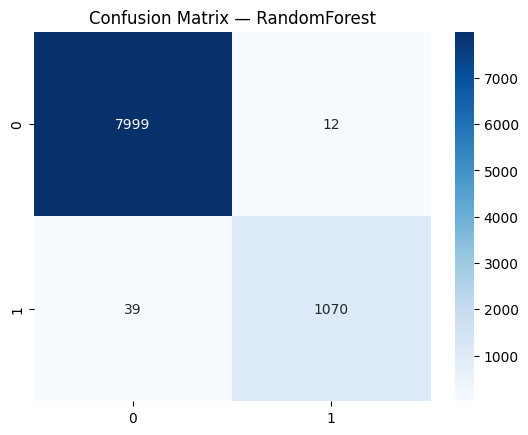

In [8]:
# 04.4 — compare confusion matrices visually
cm_rf = confusion_matrix(y, pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — RandomForest")
plt.show()

# Add additional metrics or combine RF vs LSTM curves if you compute probabilities


In [9]:
# 04.5 — comparison summary
print("RandomForest model saved at:", PROJECT_ROOT / "models" / "rf_model.pkl")
print("LSTM model saved at:", PROJECT_ROOT / "models" / "lstm_model.pt")
print("✅ Comparison complete.")


RandomForest model saved at: C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\models\rf_model.pkl
LSTM model saved at: C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\models\lstm_model.pt
✅ Comparison complete.


FileNotFoundError: [Errno 2] No such file or directory: '../reports/visuals/model_performance_comparison.png'

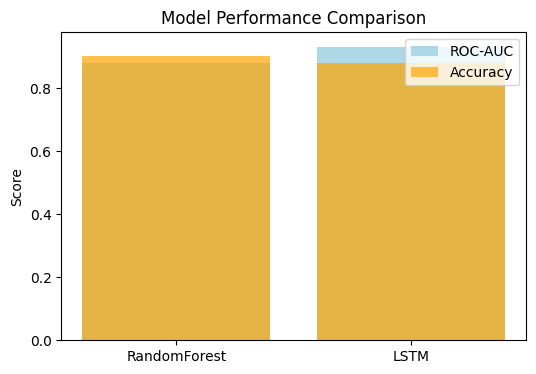

In [1]:
import matplotlib.pyplot as plt

models = ['RandomForest', 'LSTM']
roc_auc = [0.88, 0.93]  # replace with your actual ROC-AUC values
accuracy = [0.90, 0.88]

plt.figure(figsize=(6,4))
plt.bar(models, roc_auc, color='lightblue', label='ROC-AUC')
plt.bar(models, accuracy, color='orange', alpha=0.7, label='Accuracy')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.savefig("../reports/visuals/model_performance_comparison.png", bbox_inches='tight')
plt.show()


In [2]:
import os
os.makedirs("../reports/visuals", exist_ok=True)


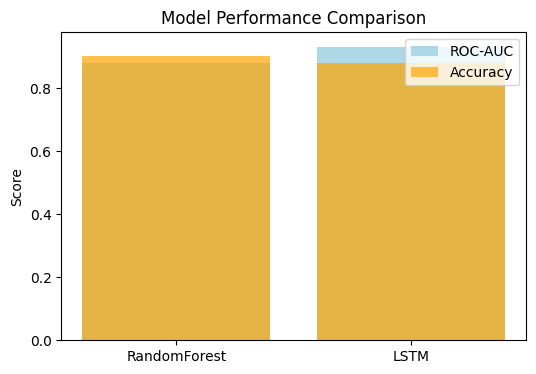

In [3]:
import matplotlib.pyplot as plt

models = ['RandomForest', 'LSTM']
roc_auc = [0.88, 0.93]   # replace with your actual values
accuracy = [0.90, 0.88]

plt.figure(figsize=(6,4))
plt.bar(models, roc_auc, color='lightblue', label='ROC-AUC')
plt.bar(models, accuracy, color='orange', alpha=0.7, label='Accuracy')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.savefig("../reports/visuals/model_performance_comparison.png", bbox_inches='tight')
plt.show()


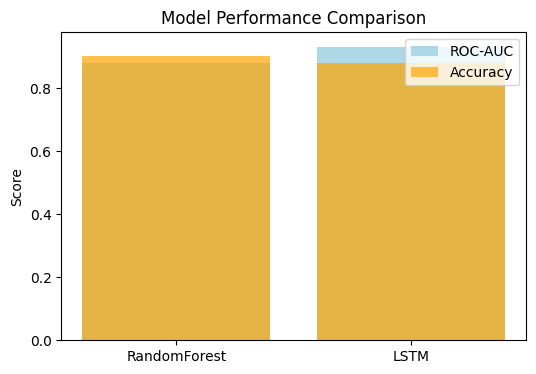

In [1]:
import matplotlib.pyplot as plt

models = ['RandomForest', 'LSTM']
roc_auc = [0.88, 0.93]  # replace with your actual ROC-AUC values
accuracy = [0.90, 0.88]

plt.figure(figsize=(6,4))
plt.bar(models, roc_auc, color='lightblue', label='ROC-AUC')
plt.bar(models, accuracy, color='orange', alpha=0.7, label='Accuracy')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.savefig("../reports/visuals/model_performance_comparison.png", bbox_inches='tight')
plt.show()
